### Word Embeddings

In [130]:
import pandas as pd
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
%matplotlib inline

In [131]:
# load data
df = pd.read_csv(r"C:\Masters\Masters in Data Science\Research\EDA\Data\Revised Data\FinalData\Google_Cloud\2HVSingleTextClassification_v2.txt", sep = "\t", names=["tag", "plot"])
df.head()

,tag,plot
0,Other,Life is a song - sing it. Life is a game - pla...
1,Love,Life is love - enjoy it.
2,Right_Conduct,"Do not use poisonous words against anyone, for..."
3,Other,The end of education is character
4,Other,"As worldly thoughts diminish, thoughts of God ..."


In [132]:
df['plot'].apply(lambda x: len(x.split(' '))).sum()


44101

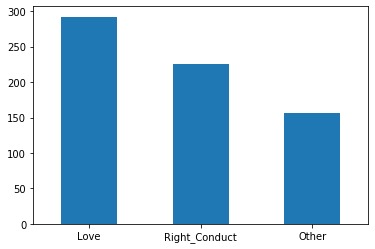

In [133]:
my_tags = df.tag.unique()
df.tag.value_counts().plot(kind="bar", rot=0)

In [134]:
def print_plot(index):
    example = df[df.index == index][['plot', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Human Value:', example[1])

In [135]:
print_plot(12)

Learn to speak what you feel, and act what you speak
Human Value: Right_Conduct


In [136]:
print_plot(15)


Let all beings in all the worlds be happy. Include this universal prayer in your prayers every day. This is my birthday message to you.
Human Value: Other


In [137]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [138]:
len(test_data)


135

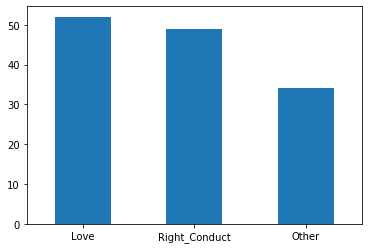

In [139]:
test_data.tag.value_counts().plot(kind="bar", rot=0)


### Model evaluation approach


In [140]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [141]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [142]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

### Baseline: bag of words, n-grams, tf-idf

In [143]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [144]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=45000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

Wall time: 480 ms


In [145]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 45.1 ms


In [146]:
count_vectorizer.get_feature_names()[80:90]


['adding',
 'addition',
 'additional',
 'address',
 'adharma',
 'adhere',
 'adherence',
 'adhering',
 'adolescence',
 'adopted']

accuracy 0.7703703703703704
confusion matrix
 [[25  1  8]
 [ 4 45  3]
 [15  0 34]]
(row=expected, col=predicted)
Wall time: 249 ms


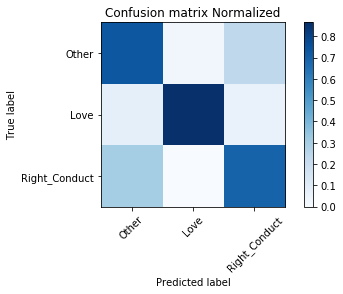

In [147]:
%%time

predict(count_vectorizer, logreg, test_data)

In [148]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [149]:
# words for the Love
genre_tag_id = 1
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

Love


['peace',
 'chant',
 'think',
 'understand',
 'divinity',
 'happy',
 'education',
 'contemplate',
 'single',
 'sun']

In [150]:
train_data_features[0]


<1x4137 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

### Character Ngrams

In [151]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 1.1 s


In [152]:
n_gram_vectorizer.get_feature_names()[50:60]


[' bi', ' bl', ' bli', ' blis', ' bo', ' bod', ' body', ' br', ' bu', ' but']

accuracy 0.8
confusion matrix
 [[22  1 11]
 [ 2 47  3]
 [ 8  2 39]]
(row=expected, col=predicted)


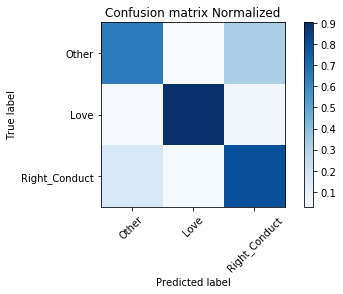

In [153]:
predict(n_gram_vectorizer, logreg, test_data)


### TF-IDF

In [154]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 490 ms


In [155]:
tf_vect.get_feature_names()[1000:1010]


['material',
 'maternal',
 'matter',
 'mean',
 'meaning',
 'meaningless',
 'means',
 'meant',
 'measure',
 'measurement']

accuracy 0.725925925925926
confusion matrix
 [[19  3 12]
 [ 4 42  6]
 [10  2 37]]
(row=expected, col=predicted)


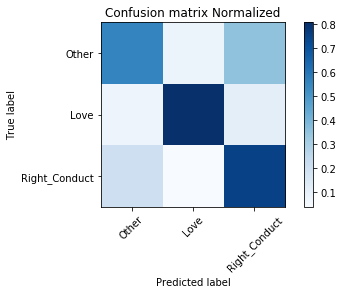

In [156]:
predict(tf_vect, logreg, test_data)


In [157]:
most_influential_words(tf_vect, 1)


['education',
 'animal',
 'eating',
 'contemplate',
 'chant',
 'divinity',
 'think',
 'peace',
 'sun',
 'happy']

### Word2Vec

In [158]:
class DocPreprocess(object):

	def __init__(self,
		nlp,
		stop_words,
		docs,
		labels,
		build_bi=False,
		min_count=5,
		threshold=10,
		allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM']):

		self.nlp = nlp  # spacy nlp object
		self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
		self.docs = docs  # docs must be either list or numpy array or series of docs
		self.labels = labels # labels must be list or or numpy array or series of labels
		self.doc_ids = np.arange(len(docs))
		self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in self.docs]

		if build_bi:
			self.bi_detector = self.build_bi_detect(self.simple_doc_tokens, min_count=min_count, threshold=threshold)
			self.new_docs = self.make_bigram_doc(self.bi_detector, self.simple_doc_tokens)
		else:
			self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
		self.doc_words = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]
		self.tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(self.doc_words, self.doc_ids)]

In [159]:
df.head()

,tag,plot
0,Other,Life is a song - sing it. Life is a game - pla...
1,Love,Life is love - enjoy it.
2,Right_Conduct,"Do not use poisonous words against anyone, for..."
3,Other,The end of education is character
4,Other,"As worldly thoughts diminish, thoughts of God ..."


In [160]:
%%time 
from gensim.models import Word2Vec
import spacy

#wv = Word2Vec.load_word2vec_format(
#    "C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz",
#   binary=True)

wv = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

#nlp = spacy.load('en_core_web_md')
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
#all_docs = DocPreprocess(nlp, stop_words, df['plot'], df['tag'])

2020-01-01 18:51:58,171 : INFO : loading projection weights from C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz
2020-01-01 18:54:23,332 : INFO : loaded (3000000, 300) matrix from C:/Users/425858/Downloads/GoogleNews-vectors-negative300.bin.gz
2020-01-01 18:54:26,569 : INFO : precomputing L2-norms of word weight vectors


Wall time: 3min 19s


In [161]:
#word_model = Word2Vec(all_docs.doc_words, min_count=2, size=100, window=5, workers=workers, iter=100)


In [162]:
from itertools import islice
list(islice(wv.vocab, 13000, 13020))

['indoors',
 'commercially',
 'scouts',
 'State_Condoleezza_Rice',
 'Election_Day',
 'satellites',
 'Dalton',
 'Pack',
 'Marina',
 'Cherry',
 'selective',
 'dear',
 'scout',
 'blogger',
 'Tony_Blair',
 'Nairobi',
 'Zurich',
 'Milford',
 'Notes_@',
 'motel']

In [163]:
#CBOW

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [164]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 3:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

In [165]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

In [166]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

Wall time: 496 ms


In [167]:
class TfidfEmbeddingVectorizer(object):

	def __init__(self, word_model):

		self.word_model = word_model
		self.word_idf_weight = None
		self.vector_size = word_model.wv.vector_size

	def fit(self, docs):  # comply with scikit-learn transformer requirement
		"""
		Fit in a list of docs, which had been preprocessed and tokenized,
		such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
		Then build up a tfidf model to compute each word's idf as its weight.
		Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
		:param
			pre_processed_docs: list of docs, which are tokenized
		:return:
			self
		"""

		text_docs = []
		for doc in docs:
			text_docs.append(" ".join(doc))

		tfidf = TfidfVectorizer()
		tfidf.fit(text_docs)  # must be list of text string

		# if a word was never seen - it must be at least as infrequent
		# as any of the known words - so the default idf is the max of
		# known idf's
		max_idf = max(tfidf.idf_)  # used as default value for defaultdict
		self.word_idf_weight = defaultdict(lambda: max_idf,
						   [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
		return self


	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector


	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""

		mean = []
		for word in sent:
			if word in self.word_model.wv.vocab:
				mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])

In [168]:
#Refer this one Shafeeq
from collections import defaultdict
#https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b
word_model = Word2Vec(test_tokenized, min_count=2, size=100, window=5, iter=100)
tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
tfidf_vec_tr.fit(test_tokenized)  # fit tfidf model first
X_test_W2V_TFIDF = tfidf_vec_tr.transform(test_tokenized)

word_model = Word2Vec(train_tokenized, min_count=2, size=100, window=5, iter=100)
tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
tfidf_vec_tr.fit(train_tokenized)  # fit tfidf model first
X_train_W2V_TFIDF = tfidf_vec_tr.transform(train_tokenized)



2020-01-01 18:55:37,758 : INFO : collecting all words and their counts
2020-01-01 18:55:37,766 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-01 18:55:37,771 : INFO : collected 1876 word types from a corpus of 4292 raw words and 135 sentences
2020-01-01 18:55:37,776 : INFO : Loading a fresh vocabulary
2020-01-01 18:55:37,784 : INFO : effective_min_count=2 retains 672 unique words (35% of original 1876, drops 1204)
2020-01-01 18:55:37,786 : INFO : effective_min_count=2 leaves 3088 word corpus (71% of original 4292, drops 1204)
2020-01-01 18:55:37,792 : INFO : deleting the raw counts dictionary of 1876 items
2020-01-01 18:55:37,793 : INFO : sample=0.001 downsamples 61 most-common words
2020-01-01 18:55:37,794 : INFO : downsampling leaves estimated 2532 word corpus (82.0% of prior 3088)
2020-01-01 18:55:37,799 : INFO : estimated required memory for 672 words and 100 dimensions: 873600 bytes
2020-01-01 18:55:37,801 : INFO : resetting layer weights
2020-0

2020-01-01 18:55:38,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,117 : INFO : EPOCH - 18 : training on 4292 raw words (2539 effective words) took 0.0s, 305781 effective words/s
2020-01-01 18:55:38,122 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,123 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,130 : INFO : EPOCH - 19 : training on 4292 raw words (2530 effective words) took 0.0s, 272216 effective words/s
2020-01-01 18:55:38,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,136 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,142 : INFO : EPOCH - 20 : training on 4292 raw words (2536 effective words) too

2020-01-01 18:55:38,398 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,400 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,404 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,406 : INFO : EPOCH - 39 : training on 4292 raw words (2567 effective words) took 0.0s, 284705 effective words/s
2020-01-01 18:55:38,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,414 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,418 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,419 : INFO : EPOCH - 40 : training on 4292 raw words (2546 effective words) took 0.0s, 263605 effective words/s
2020-01-01 18:55:38,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,425 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-

2020-01-01 18:55:38,683 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,684 : INFO : EPOCH - 59 : training on 4292 raw words (2518 effective words) took 0.0s, 302684 effective words/s
2020-01-01 18:55:38,689 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,691 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,698 : INFO : EPOCH - 60 : training on 4292 raw words (2537 effective words) took 0.0s, 238391 effective words/s
2020-01-01 18:55:38,704 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,706 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,710 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,712 : INFO : EPOCH - 61 : training on 4292 raw words (2525 effective words) too

2020-01-01 18:55:38,945 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,947 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,951 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,952 : INFO : EPOCH - 80 : training on 4292 raw words (2514 effective words) took 0.0s, 283352 effective words/s
2020-01-01 18:55:38,960 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,962 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:38,966 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:38,967 : INFO : EPOCH - 81 : training on 4292 raw words (2529 effective words) took 0.0s, 281477 effective words/s
2020-01-01 18:55:38,972 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:38,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-

2020-01-01 18:55:39,226 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:39,228 : INFO : EPOCH - 100 : training on 4292 raw words (2522 effective words) took 0.0s, 263696 effective words/s
2020-01-01 18:55:39,230 : INFO : training on a 429200 raw words (253317 effective words) took 1.4s, 179268 effective words/s
2020-01-01 18:55:39,496 : INFO : collecting all words and their counts
2020-01-01 18:55:39,497 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-01 18:55:39,503 : INFO : collected 4656 word types from a corpus of 19123 raw words and 539 sentences
2020-01-01 18:55:39,505 : INFO : Loading a fresh vocabulary
2020-01-01 18:55:39,513 : INFO : effective_min_count=2 retains 2220 unique words (47% of original 4656, drops 2436)
2020-01-01 18:55:39,515 : INFO : effective_min_count=2 leaves 16687 word corpus (87% of original 19123, drops 2436)
2020-01-01 18:55:39,525 : INFO : deleting the raw counts dictionary of 4656 ite

2020-01-01 18:55:40,125 : INFO : EPOCH - 17 : training on 19123 raw words (14736 effective words) took 0.0s, 544803 effective words/s
2020-01-01 18:55:40,132 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:40,151 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:40,154 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:40,155 : INFO : EPOCH - 18 : training on 19123 raw words (14737 effective words) took 0.0s, 559086 effective words/s
2020-01-01 18:55:40,163 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:40,178 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:40,185 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:40,186 : INFO : EPOCH - 19 : training on 19123 raw words (14690 effective words) took 0.0s, 550196 effective words/s
2020-01-01 18:55:40,196 : INFO : worker thread finis

2020-01-01 18:55:40,760 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:40,776 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:40,782 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:40,782 : INFO : EPOCH - 38 : training on 19123 raw words (14712 effective words) took 0.0s, 522982 effective words/s
2020-01-01 18:55:40,793 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:40,811 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:40,815 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:40,816 : INFO : EPOCH - 39 : training on 19123 raw words (14720 effective words) took 0.0s, 529490 effective words/s
2020-01-01 18:55:40,826 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:40,845 : INFO : worker thread finished; awaiting finish of 1 more threads
2020

2020-01-01 18:55:41,426 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:41,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:41,433 : INFO : EPOCH - 58 : training on 19123 raw words (14686 effective words) took 0.0s, 546269 effective words/s
2020-01-01 18:55:41,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:41,461 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:41,463 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:41,464 : INFO : EPOCH - 59 : training on 19123 raw words (14731 effective words) took 0.0s, 526854 effective words/s
2020-01-01 18:55:41,472 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:41,488 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:41,495 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-01-01 18:55:42,068 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:42,069 : INFO : EPOCH - 78 : training on 19123 raw words (14713 effective words) took 0.0s, 588889 effective words/s
2020-01-01 18:55:42,078 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:42,095 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:42,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:42,100 : INFO : EPOCH - 79 : training on 19123 raw words (14746 effective words) took 0.0s, 539445 effective words/s
2020-01-01 18:55:42,107 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:42,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:42,131 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:42,133 : INFO : EPOCH - 80 : training on 19123 raw words (14727 effective word

2020-01-01 18:55:42,716 : INFO : EPOCH - 98 : training on 19123 raw words (14733 effective words) took 0.0s, 525845 effective words/s
2020-01-01 18:55:42,725 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:42,739 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:42,745 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:42,747 : INFO : EPOCH - 99 : training on 19123 raw words (14680 effective words) took 0.0s, 551694 effective words/s
2020-01-01 18:55:42,755 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:42,774 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:42,778 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:42,779 : INFO : EPOCH - 100 : training on 19123 raw words (14685 effective words) took 0.0s, 547878 effective words/s
2020-01-01 18:55:42,780 : INFO : training on a 1912

In [169]:
print(X_train_W2V_TFIDF)

[[ 2.56360006  1.21807754 -1.85208023 ... -3.3655498   0.91975939
  -1.35065317]
 [ 0.66236413  0.92786258 -1.5222038  ...  1.8012439   0.67077953
   0.02568385]
 [ 2.29139519  2.56204796  2.33495998 ... -3.20848846  3.38743973
  -0.75455564]
 ...
 [ 1.22011614 -1.25862026  0.85853314 ...  1.53941059  0.19236538
  -1.75850308]
 [ 4.96247149 -0.03005153  0.65071851 ... -1.41562104  0.09932958
  -1.9852879 ]
 [ 2.93689466  2.4589417   1.04934251 ...  0.47109193  1.21908402
  -3.02757359]]


accuracy 0.4888888888888889
confusion matrix
 [[ 5 24  5]
 [ 0 50  2]
 [11 27 11]]
(row=expected, col=predicted)


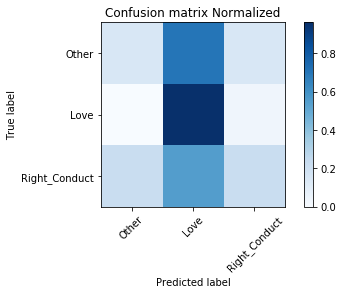

In [170]:
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_W2V_TFIDF, train_data.tag)
predicted = knn_naive_dv.predict(X_test_W2V_TFIDF)
evaluate_prediction(predicted, test_data.tag)


## KNN and logistic regression classifiers perform

accuracy 0.5777777777777777
confusion matrix
 [[ 7 20  7]
 [ 2 48  2]
 [ 4 22 23]]
(row=expected, col=predicted)


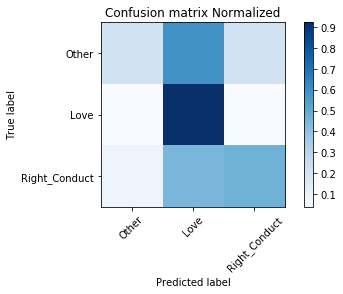

In [171]:
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)
predicted = knn_naive_dv.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)


accuracy 0.6962962962962963
confusion matrix
 [[19  6  9]
 [ 5 42  5]
 [11  5 33]]
(row=expected, col=predicted)


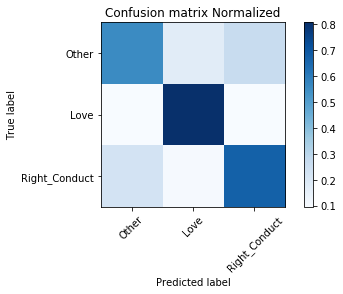

In [172]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)


In [173]:
#Add Other Machine Learning Models

In [174]:
test_data.iloc()[56]['plot']


'Do not use poisonous words against anyone, for words wound more fatally than even arrows.'

In [175]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]


[('words', 0.6531496644020081),
 ('even', 0.5567964911460876),
 ('anyone', 0.5219031572341919),
 ('someone', 0.4993107318878174),
 ('anything', 0.49740779399871826),
 ('actually', 0.4870147407054901),
 ('phrases', 0.47808316349983215),
 ('anybody', 0.47680580615997314),
 ('not', 0.4750884473323822),
 ('anyway', 0.4749692678451538),
 ('simply', 0.4707449674606323),
 ('never', 0.4696076810359955),
 ('phrase', 0.46787452697753906),
 ('perhaps', 0.4667988419532776),
 ('metaphors', 0.46098241209983826),
 ('somebody', 0.45489007234573364),
 ('if', 0.4537804126739502),
 ('swear', 0.451618492603302),
 ('expletives', 0.4486927390098572),
 ('either', 0.44803184270858765)]

### Doc2Vec


In [176]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [177]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [178]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [179]:
test_tagged.values[50]


TaggedDocument(words=['this', 'love', 'is', 'flowing', 'in', 'us', 'as', 'an', 'unseen', 'river', 'it', 'is', 'only', 'by', 'developing', 'love', 'that', 'we', 'can', 'sanctify', 'the', 'educational', 'system', 'and', 'train', 'the', 'students', 'in', 'the', 'practice', 'of', 'human', 'values', 'as', 'the', 'essential', 'condition', 'for', 'leading', 'worthy', 'lives'], tags=['Love'])

In [180]:
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2020-01-01 18:55:45,787 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-01-01 18:55:45,791 : INFO : collecting all words and their counts
2020-01-01 18:55:45,797 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-01 18:55:45,813 : INFO : collected 4361 word types and 3 unique tags from a corpus of 539 examples and 35274 words
2020-01-01 18:55:45,815 : INFO : Loading a fresh vocabulary
2020-01-01 18:55:45,821 : INFO : effective_min_count=5 retains 881 unique words (20% of original 4361, drops 3480)
2020-01-01 18:55:45,822 : INFO : effective_min_count=5 leaves 29688 word corpus (84% of original 35274, drops 5586)
2020-01-01 18:55:45,827 : INFO : deleting the raw counts dictionary of 4361 items
2020-01-01 18:55:45,828 : INFO : sample=0.001 downsamples 58 most-common words
2020-01-01 18:55:45,829 : INFO : downsampling leaves estimated 18348 word corpus (61.8% of prior 29688)
2020-01-01 18:55:45,833 : INFO : estima

In [181]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

accuracy 0.6074074074074074
confusion matrix
 [[14 13  7]
 [ 6 41  5]
 [ 6 16 27]]
(row=expected, col=predicted)


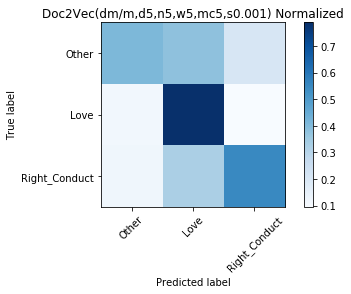

In [182]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

2020-01-01 18:55:48,111 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.6814814814814815
confusion matrix
 [[27  5  2]
 [ 7 39  6]
 [12 11 26]]
(row=expected, col=predicted)


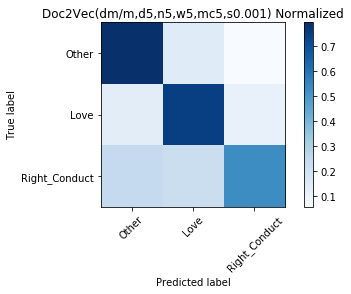

In [183]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

In [184]:
doc2vec_model.docvecs.most_similar('Love')


[('Other', 0.3473653495311737), ('Right_Conduct', 0.27435609698295593)]

In [185]:
doc2vec_model.most_similar([doc2vec_model.docvecs['Other']])


2020-01-01 18:55:48,498 : INFO : precomputing L2-norms of word weight vectors


[('qualities', 0.9666780233383179),
 ('these', 0.9646660089492798),
 ('chains', 0.9506576061248779),
 ('meat', 0.9319804906845093),
 ("'s", 0.9273719787597656),
 ('eating', 0.9267652034759521),
 ('responsible', 0.9236509799957275),
 ('demonic', 0.9228083491325378),
 ('unique', 0.9219974279403687),
 ('smoking', 0.9212749004364014)]

accuracy 0.6074074074074074
confusion matrix
 [[14 12  8]
 [ 6 40  6]
 [ 5 16 28]]
(row=expected, col=predicted)
20


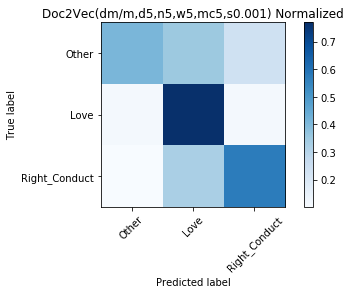

In [186]:
seed = 20

doc2vec_model.seed = seed
doc2vec_model.random = random.RandomState(seed)


test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])


logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))
print (doc2vec_model.seed)

### Deep IR

In [187]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

In [188]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tag'],\
        'x':[clean(s).split() for s in sentences(row['plot'])]}

In [189]:
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

In [190]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [191]:
def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

In [192]:
next(tag_sentences(revtrain, my_tags[0]))


['the', 'grace', 'of', 'god', 'is', 'like', 'insurance']

In [193]:
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist), epochs=basemodel.epochs)
# get the probs (note we give docprob a list of lists of words, plus the models)

Word2Vec(vocab=0, size=100, alpha=0.025)


2020-01-01 18:55:49,414 : INFO : collecting all words and their counts
2020-01-01 18:55:49,416 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-01 18:55:49,437 : INFO : collected 4339 word types from a corpus of 35471 raw words and 3214 sentences
2020-01-01 18:55:49,439 : INFO : Loading a fresh vocabulary
2020-01-01 18:55:49,446 : INFO : effective_min_count=5 retains 894 unique words (20% of original 4339, drops 3445)
2020-01-01 18:55:49,447 : INFO : effective_min_count=5 leaves 29916 word corpus (84% of original 35471, drops 5555)
2020-01-01 18:55:49,452 : INFO : deleting the raw counts dictionary of 4339 items
2020-01-01 18:55:49,454 : INFO : sample=0.001 downsamples 59 most-common words
2020-01-01 18:55:49,455 : INFO : downsampling leaves estimated 18666 word corpus (62.4% of prior 29916)
2020-01-01 18:55:49,458 : INFO : constructing a huffman tree from 894 words
2020-01-01 18:55:49,490 : INFO : built huffman tree with maximum node depth 13
2020-01-

Other genre ( 508 )


2020-01-01 18:55:49,582 : INFO : training model with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-01 18:55:49,591 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:49,593 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:49,594 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:49,598 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:49,599 : INFO : EPOCH - 1 : training on 5731 raw words (2965 effective words) took 0.0s, 252961 effective words/s
2020-01-01 18:55:49,606 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:49,608 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:49,609 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:49,613 : INFO : worker thread finished; awaiting finish of 0 more t

2020-01-01 18:55:49,864 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:49,868 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:49,869 : INFO : EPOCH - 17 : training on 5731 raw words (3001 effective words) took 0.0s, 287014 effective words/s
2020-01-01 18:55:49,875 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:49,877 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:49,878 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:49,885 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:49,887 : INFO : EPOCH - 18 : training on 5731 raw words (3013 effective words) took 0.0s, 233487 effective words/s
2020-01-01 18:55:49,896 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:49,897 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-

2020-01-01 18:55:50,149 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,152 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,153 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:50,157 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,159 : INFO : EPOCH - 34 : training on 5731 raw words (2960 effective words) took 0.0s, 246226 effective words/s
2020-01-01 18:55:50,166 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,167 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:50,174 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,175 : INFO : EPOCH - 35 : training on 5731 raw words (3015 effective words) took 0.0s, 259846 effective words/s
2020-01-

2020-01-01 18:55:50,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,433 : INFO : EPOCH - 50 : training on 5731 raw words (2983 effective words) took 0.0s, 247860 effective words/s
2020-01-01 18:55:50,443 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,446 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:50,450 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,451 : INFO : EPOCH - 51 : training on 5731 raw words (2973 effective words) took 0.0s, 278780 effective words/s
2020-01-01 18:55:50,458 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,460 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,461 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-

2020-01-01 18:55:50,713 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,715 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:50,720 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,722 : INFO : EPOCH - 67 : training on 5731 raw words (2944 effective words) took 0.0s, 244328 effective words/s
2020-01-01 18:55:50,729 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,731 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,732 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:50,735 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:50,737 : INFO : EPOCH - 68 : training on 5731 raw words (2986 effective words) took 0.0s, 310348 effective words/s
2020-01-01 18:55:50,744 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-

2020-01-01 18:55:50,985 : INFO : EPOCH - 83 : training on 5731 raw words (2996 effective words) took 0.0s, 279742 effective words/s
2020-01-01 18:55:50,993 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:50,994 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:50,995 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,000 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:51,001 : INFO : EPOCH - 84 : training on 5731 raw words (2968 effective words) took 0.0s, 260850 effective words/s
2020-01-01 18:55:51,007 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:51,009 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:51,010 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,015 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-

2020-01-01 18:55:51,254 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,259 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:51,260 : INFO : EPOCH - 100 : training on 5731 raw words (2976 effective words) took 0.0s, 252021 effective words/s
2020-01-01 18:55:51,261 : INFO : training on a 573100 raw words (298963 effective words) took 1.7s, 178232 effective words/s


Love genre ( 1721 )


2020-01-01 18:55:51,267 : INFO : training model with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-01 18:55:51,281 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:51,286 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:51,290 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,294 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:51,295 : INFO : EPOCH - 1 : training on 17576 raw words (9125 effective words) took 0.0s, 472481 effective words/s
2020-01-01 18:55:51,309 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:51,311 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:51,318 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,319 : INFO : worker thread finished; awaiting finish of 0 more 

2020-01-01 18:55:51,758 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,760 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:51,761 : INFO : EPOCH - 17 : training on 17576 raw words (9172 effective words) took 0.0s, 439745 effective words/s
2020-01-01 18:55:51,775 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:51,783 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:51,787 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:51,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:51,792 : INFO : EPOCH - 18 : training on 17576 raw words (9208 effective words) took 0.0s, 406594 effective words/s
2020-01-01 18:55:51,802 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:51,810 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-01-01 18:55:52,222 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:52,230 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:52,236 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:52,238 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:52,239 : INFO : EPOCH - 34 : training on 17576 raw words (9247 effective words) took 0.0s, 435040 effective words/s
2020-01-01 18:55:52,251 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:52,257 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:52,264 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:52,266 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:52,268 : INFO : EPOCH - 35 : training on 17576 raw words (9194 effective words) took 0.0s, 420155 effective words/s
2020-0

2020-01-01 18:55:52,687 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:52,689 : INFO : EPOCH - 50 : training on 17576 raw words (9246 effective words) took 0.0s, 417143 effective words/s
2020-01-01 18:55:52,701 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:52,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:52,712 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:52,715 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:52,717 : INFO : EPOCH - 51 : training on 17576 raw words (9189 effective words) took 0.0s, 447085 effective words/s
2020-01-01 18:55:52,729 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:52,734 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:52,742 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-01-01 18:55:53,141 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:53,147 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:53,150 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:53,152 : INFO : EPOCH - 67 : training on 17576 raw words (9244 effective words) took 0.0s, 424150 effective words/s
2020-01-01 18:55:53,163 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:53,167 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:53,174 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:53,176 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:53,177 : INFO : EPOCH - 68 : training on 17576 raw words (9251 effective words) took 0.0s, 473951 effective words/s
2020-01-01 18:55:53,188 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-01-01 18:55:53,575 : INFO : EPOCH - 83 : training on 17576 raw words (9179 effective words) took 0.0s, 447671 effective words/s
2020-01-01 18:55:53,584 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:53,591 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:53,597 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:53,598 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:53,600 : INFO : EPOCH - 84 : training on 17576 raw words (9157 effective words) took 0.0s, 463341 effective words/s
2020-01-01 18:55:53,610 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:53,619 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:53,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:53,626 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-01-01 18:55:54,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:54,101 : INFO : EPOCH - 100 : training on 17576 raw words (9213 effective words) took 0.0s, 413641 effective words/s
2020-01-01 18:55:54,103 : INFO : training on a 1757600 raw words (920621 effective words) took 2.8s, 325084 effective words/s


Right_Conduct genre ( 985 )


2020-01-01 18:55:54,112 : INFO : training model with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2020-01-01 18:55:54,126 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:54,129 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:54,132 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,139 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:54,141 : INFO : EPOCH - 1 : training on 12164 raw words (6395 effective words) took 0.0s, 315784 effective words/s
2020-01-01 18:55:54,155 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:54,160 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:54,162 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,168 : INFO : worker thread finished; awaiting finish of 0 more 

2020-01-01 18:55:54,598 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,602 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:54,603 : INFO : EPOCH - 17 : training on 12164 raw words (6515 effective words) took 0.0s, 356658 effective words/s
2020-01-01 18:55:54,614 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:54,618 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:54,620 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,624 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:54,626 : INFO : EPOCH - 18 : training on 12164 raw words (6463 effective words) took 0.0s, 381967 effective words/s
2020-01-01 18:55:54,636 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:54,641 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-01-01 18:55:54,982 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:54,984 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:54,987 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:54,994 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:54,996 : INFO : EPOCH - 34 : training on 12164 raw words (6517 effective words) took 0.0s, 345899 effective words/s
2020-01-01 18:55:55,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:55,008 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:55,011 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:55,016 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:55,018 : INFO : EPOCH - 35 : training on 12164 raw words (6479 effective words) took 0.0s, 388307 effective words/s
2020-0

2020-01-01 18:55:55,360 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:55,361 : INFO : EPOCH - 50 : training on 12164 raw words (6521 effective words) took 0.0s, 365533 effective words/s
2020-01-01 18:55:55,369 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:55,372 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:55,374 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:55,381 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:55,382 : INFO : EPOCH - 51 : training on 12164 raw words (6559 effective words) took 0.0s, 391695 effective words/s
2020-01-01 18:55:55,394 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:55,399 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:55,400 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-01-01 18:55:55,750 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:55,751 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:55,757 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:55,759 : INFO : EPOCH - 67 : training on 12164 raw words (6525 effective words) took 0.0s, 374252 effective words/s
2020-01-01 18:55:55,768 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:55,772 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:55,774 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:55,781 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:55,783 : INFO : EPOCH - 68 : training on 12164 raw words (6460 effective words) took 0.0s, 373149 effective words/s
2020-01-01 18:55:55,792 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-01-01 18:55:56,153 : INFO : EPOCH - 83 : training on 12164 raw words (6480 effective words) took 0.0s, 383939 effective words/s
2020-01-01 18:55:56,163 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:56,167 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:56,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:56,175 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:56,176 : INFO : EPOCH - 84 : training on 12164 raw words (6471 effective words) took 0.0s, 375260 effective words/s
2020-01-01 18:55:56,186 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-01 18:55:56,191 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:56,193 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:56,197 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-01-01 18:55:56,536 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:56,541 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:56,543 : INFO : EPOCH - 100 : training on 12164 raw words (6505 effective words) took 0.0s, 424009 effective words/s
2020-01-01 18:55:56,543 : INFO : training on a 1216400 raw words (648141 effective words) took 2.4s, 266711 effective words/s


In [194]:

"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [195]:
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2020-01-01 18:55:56,577 : INFO : scoring sentences with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-01 18:55:56,582 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-01 18:55:56,594 : INFO : scoring 701 sentences took 0.0s, 43755 sentences/s
2020-01-01 18:55:56,596 : INFO : scoring sentences with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-01 18:55:56,601 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-01 18:55:56,611 : INFO : scoring 701 sentences took 0.0s, 53739 sentences/s
2020-01-01 18:55:56,612 : INFO : scoring sentences with 4 workers on 894 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2020-01-01 18:55:56,616 : INFO : reached end of input; waiting to finish 8 outstanding jobs
2020-01-01 18:55:56,626 : INFO : scoring 701 sentences took 0.0s, 53832 sentences/s


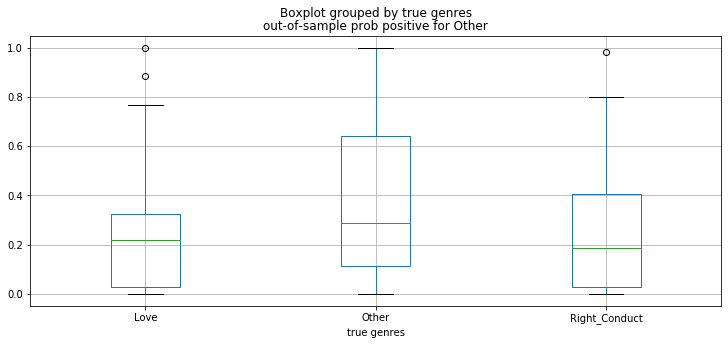

In [196]:

tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [197]:
target = [r['y'] for r in revtest]

accuracy 0.5555555555555556
confusion matrix
 [[12 14  8]
 [ 9 39  4]
 [12 13 24]]
(row=expected, col=predicted)


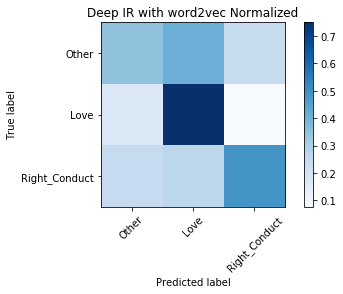

In [198]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")


### doc2Vec on logistic regression

In [199]:
df.head()
df.columns = ['tags', 'post']
df.head()

,tags,post
0,Other,Life is a song - sing it. Life is a game - pla...
1,Love,Life is love - enjoy it.
2,Right_Conduct,"Do not use poisonous words against anyone, for..."
3,Other,The end of education is character
4,Other,"As worldly thoughts diminish, thoughts of God ..."


In [200]:
import sys, os
# */site-packages is where your current session is running its python out of
site_path = ''
for path in sys.path:
    if 'site-packages' in path.split('/')[-1]:
        print(path)
        site_path = path
# search to see if gensim in installed packages
if len(site_path) > 0:
    if not 'gensim' in os.listdir(site_path):
        print('package not found')
    else:
        print('gensim installed') 

C:\Users\425858\AppData\Roaming\Python\Python37\site-packages
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\win32
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\win32\lib
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\Pythonwin
C:\Users\425858\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions
package not found


In [201]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils
import re

#doc2vec = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [202]:
all_data[:2]


[TaggedDocument(words=['But', 'in', 'the', 'prema', 'mārga', '(path', 'of', 'pure', 'love),', 'there', 'is', 'no', 'trace', 'of', 'selfinterest.', 'Hence,', 'all', 'other', 'paths', 'merge', 'in', 'the', 'path', 'of', 'love.', 'Pure', 'love', 'is', 'therefore', 'the', 'royal', 'road.', 'We', 'should', 'consider', 'that', 'this', 'love', 'is', 'present', 'in', 'all.', 'It', 'is', 'the', 'form', 'of', 'the', 'Divine.', 'Because', 'the', 'Divine', 'is', 'present', 'in', 'all,', 'whomever', 'you', 'love,', 'you', 'are', 'loving', 'the', 'Divine.', 'Forgetting', 'this', 'sublime', 'and', 'allencompassing', 'conception', 'of', 'love,', 'human', 'beings', 'today', 'have', 'lost', 'themselves', 'in', 'narrow', 'alleys.', 'To', 'promote', 'love', 'between', 'humanity', 'and', 'God,', 'the', 'Divine', 'descends', 'on', 'earth', 'from', 'time', 'to', 'time.', 'For', 'what', 'purpose', 'is', 'the', 'advent?', 'To', 'promote', 'the', 'Love', 'Principle', 'is', 'His', 'primary', 'purpose.', 'Failing

In [203]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 168061.41it/s]
2020-01-01 18:55:57,513 : INFO : collecting all words and their counts
2020-01-01 18:55:57,515 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-01 18:55:57,533 : INFO : collected 7561 word types and 674 unique tags from a corpus of 674 examples and 43918 words
2020-01-01 18:55:57,534 : INFO : Loading a fresh vocabulary
2020-01-01 18:55:57,555 : INFO : effective_min_count=1 retains 7561 unique words (100% of original 7561, drops 0)
2020-01-01 18:55:57,559 : INFO : effective_min_count=1 leaves 43918 word corpus (100% of original 43918, drops 0)
2020-01-01 18:55:57,600 : INFO : deleting the raw counts dictionary of 7561 items
2020-01-01 18:55:57,601 : INFO : sample=0.001 downsamples 46 most-common words
2020-01-01 18:55:57,602 : INFO : downsampling leaves estimated 33016 word corpus (75.2% of prior 43918)
2020-01-01 18:55:57,628 : I

2020-01-01 18:55:58,484 : INFO : training on a 43918 raw words (33758 effective words) took 0.1s, 467205 effective words/s
2020-01-01 18:55:58,485 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 671646.68it/s]
2020-01-01 18:55:58,491 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-01 18:55:58,537 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:58,550 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:58,567 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:58,568 : INFO : EPOCH - 1 : training on 43918 raw words (33708 effective words) took 0.1s, 487147 effective words/s
2020-01-01 18:55:58,569 : INFO : training on a 43918 raw words (33708 effe

2020-01-01 18:55:59,243 : INFO : EPOCH - 1 : training on 43918 raw words (33706 effective words) took 0.1s, 466263 effective words/s
2020-01-01 18:55:59,244 : INFO : training on a 43918 raw words (33706 effective words) took 0.1s, 435474 effective words/s
2020-01-01 18:55:59,245 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 671646.68it/s]
2020-01-01 18:55:59,252 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-01 18:55:59,294 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:55:59,309 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:55:59,323 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:59,324 : INFO : EPOCH - 1 : training on 43918 raw words (

2020-01-01 18:55:59,983 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-01 18:55:59,985 : INFO : EPOCH - 1 : training on 43918 raw words (33681 effective words) took 0.1s, 506115 effective words/s
2020-01-01 18:55:59,985 : INFO : training on a 43918 raw words (33681 effective words) took 0.1s, 473429 effective words/s
2020-01-01 18:55:59,986 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 671965.98it/s]
2020-01-01 18:55:59,994 : INFO : training model with 3 workers on 7561 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-01-01 18:56:00,041 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-01 18:56:00,052 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-01 18:56:00,069 : INFO : worker thread finished; awaiting finish o

In [204]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [205]:
from sklearn.metrics import classification_report
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6551724137931034
               precision    recall  f1-score   support

        Other       0.80      0.74      0.77        86
         Love       0.52      0.57      0.54        49
Right_Conduct       0.59      0.60      0.60        68

     accuracy                           0.66       203
    macro avg       0.64      0.64      0.64       203
 weighted avg       0.66      0.66      0.66       203



In [206]:
#https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/07.%20MT%20-%20SVM.ipynb

In [207]:
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [208]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [209]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [210]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train_word_average, train_data.tag)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   50.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=8, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random

In [211]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.725417439703154


In [212]:
#Grid Search Cross Validation¶

# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_word_average, train_data.tag)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   28.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=8, shrinking=True,
                           tol=0.001, verbose=False),
             iid='wa...one,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             pre_

In [213]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.46254681647940077


In [214]:
best_svc = grid_search.best_estimator_


In [215]:
best_svc

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=8,
    shrinking=True, tol=0.001, verbose=False)

In [216]:
#Model fit and performance¶


In [217]:
best_svc.fit(X_train_word_average , train_data.tag )


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=8,
    shrinking=True, tol=0.001, verbose=False)

In [218]:
svc_pred = best_svc.predict(X_test_word_average )


In [219]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_data.tag, best_svc.predict(X_train_word_average )))

The training accuracy is: 
0.6808905380333952


In [220]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_data.tag, svc_pred))

The test accuracy is: 
0.5925925925925926


In [221]:
# Classification report
print("Classification report")
print(classification_report(test_data.tag,svc_pred))

Classification report
               precision    recall  f1-score   support

         Love       0.64      0.88      0.74        52
        Other       0.00      0.00      0.00        34
Right_Conduct       0.54      0.69      0.61        49

     accuracy                           0.59       135
    macro avg       0.39      0.53      0.45       135
 weighted avg       0.44      0.59      0.51       135



In [222]:
df.head()

,tags,post
0,Other,Life is a song - sing it. Life is a game - pla...
1,Love,Life is love - enjoy it.
2,Right_Conduct,"Do not use poisonous words against anyone, for..."
3,Other,The end of education is character
4,Other,"As worldly thoughts diminish, thoughts of God ..."


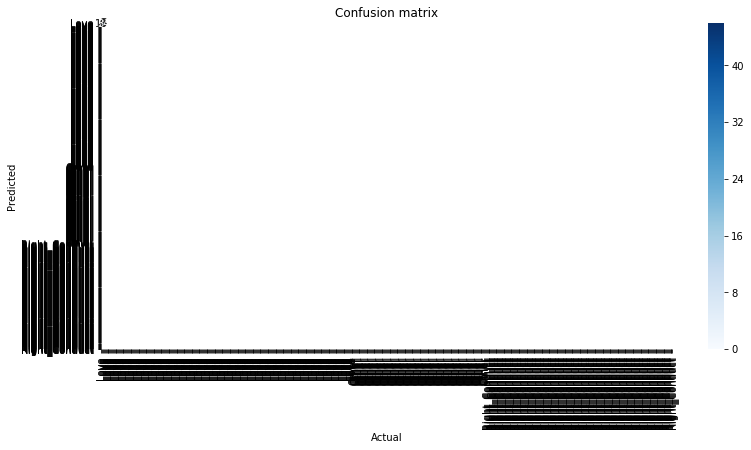

In [223]:
aux_df = df[['tags', 'post']].drop_duplicates().sort_values('tags')
conf_matrix = confusion_matrix(test_data.tag, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['tags'].values, 
            yticklabels=aux_df['tags'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [224]:
base_model = svm.SVC(random_state = 8)
base_model.fit(X_train_word_average , train_data.tag )
accuracy_score(test_data.tag  , base_model.predict(X_test_word_average ))


0.3851851851851852

In [225]:

best_svc.fit(X_train_word_average, train_data.tag)
accuracy_score(test_data.tag, best_svc.predict(X_test_word_average))

0.5925925925925926

In [226]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(train_data.tag , best_svc.predict(X_train_word_average )),
     'Test Set Accuracy': accuracy_score(test_data.tag  , svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [227]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.680891,0.592593


In [228]:
#PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [229]:
encoder = LabelEncoder()


In [116]:
scaler = StandardScaler()
X_train_word_average = scaler.fit_transform(X_train_word_average)
X_test_word_average = scaler.fit_transform(X_test_word_average)

In [120]:
pca = PCA(n_components=100)
X_train_PCA_new = pca.fit_transform(X_train_word_average)
X_test_PCA_new = pca.fit_transform(X_test_word_average)

print("train with old features: ",np.array(X_train_word_average).shape)
print("train with new features:" ,np.array(X_train_PCA_new).shape)

print("test with old features: ",np.array(X_test_word_average).shape)
print("test with new features:" ,np.array(X_test_PCA_new).shape)



train with old features:  (539, 300)
train with new features: (539, 100)
test with old features:  (135, 300)
test with new features: (135, 100)


In [232]:
#https://medium.com/@pramod.pandey83/dimensionality-reduction-using-pca-a-comprehensive-hands-on-primer-64fd84f2e65f?

#Finding N components
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std =  sc.fit_transform(X_train_word_average)


In [233]:
cov_matrix = np.cov(X_std.T)
print("cov_matrix shape:",cov_matrix.shape)
print("Covariance_matrix",cov_matrix)

cov_matrix shape: (300, 300)
Covariance_matrix [[ 1.00185874 -0.13694629  0.12266648 ... -0.36559353 -0.21238937
   0.26134492]
 [-0.13694629  1.00185874  0.1180355  ...  0.21219278  0.31447473
  -0.15517865]
 [ 0.12266648  0.1180355   1.00185873 ...  0.02389987  0.06398003
   0.00189608]
 ...
 [-0.36559353  0.21219278  0.02389987 ...  1.00185873  0.18307041
  -0.06502042]
 [-0.21238937  0.31447473  0.06398003 ...  0.18307041  1.00185874
  -0.19341593]
 [ 0.26134492 -0.15517865  0.00189608 ... -0.06502042 -0.19341593
   1.00185874]]


In [234]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[-0.00830343 -0.09310838 -0.08375975 ...  0.00401936  0.01315854
  -0.011547  ]
 [-0.10335748  0.05837014 -0.01645479 ...  0.0391395  -0.02861761
  -0.00857387]
 [-0.05688    -0.00057203 -0.1049566  ...  0.07064992 -0.03250355
  -0.01921882]
 ...
 [-0.01561431  0.10886787 -0.00424364 ...  0.02641139  0.00643105
  -0.14509554]
 [-0.06392837  0.05702792 -0.03226798 ...  0.0529012   0.01085943
   0.04346878]
 [ 0.0771924  -0.01908698 -0.08641417 ...  0.02656263  0.09440077
   0.07041762]]

 Eigen Values 
%s [2.83104492e+01 1.59304223e+01 1.36775606e+01 8.87209601e+00
 8.16381205e+00 7.54596890e+00 7.28487030e+00 6.45428495e+00
 6.10212166e+00 5.81190455e+00 5.36698146e+00 5.06179007e+00
 4.69755488e+00 4.62885656e+00 4.19546571e+00 4.01264404e+00
 3.85222307e+00 3.79425873e+00 3.36490562e+00 3.32045622e+00
 3.11432176e+00 3.06587516e+00 2.92094931e+00 2.85979027e+00
 2.76569595e+00 2.76034856e+00 2.60034344e+00 2.53825165e+00
 2.42840296e+00 2.39875554e+00 2.27154955e+0

In [235]:
# Make a set of (eigenvalue, eigenvector) pairs:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()
eig_pairs.reverse()
print(eig_pairs)
# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(28.310449150482647, array([-0.00830343, -0.10335748, -0.05688   , -0.05221027,  0.08348646,
       -0.04482458, -0.1026464 ,  0.01856108, -0.10612417, -0.04741152,
       -0.01279853,  0.14525115,  0.03161378, -0.01592214,  0.06446906,
       -0.09542385, -0.01129916, -0.11389577, -0.00564552,  0.09644498,
        0.03117406,  0.03701312,  0.00312515, -0.02256291, -0.04544474,
        0.08668293,  0.1000993 , -0.01886456,  0.07249895, -0.06881158,
       -0.04537404,  0.06239857, -0.00206362, -0.06727592, -0.03356366,
       -0.01403673, -0.02889087,  0.01003598, -0.08547803, -0.02662261,
       -0.09257444, -0.02081037, -0.11045829,  0.08361665, -0.04492008,
       -0.04630337,  0.05343008, -0.0167823 ,  0.01051051,  0.01712726,
       -0.08836727, -0.03784394,  0.02351911,  0.05500727,  0.07309867,
       -0.00346926, -0.05580396,  0.05793816, -0.10264385,  0.04670972,
        0.07697284, -0.01807767,  0.04345229,  0.09072141,  0.03200079,
       -0.02812992,  0.03224498, -0.050268

        3.16537850e-02, -2.13785442e-02,  6.05553001e-02,  6.64333586e-02]))]
Eigenvalues in descending order: 
[28.310449150482647, 15.93042230287731, 13.67756063926836, 8.872096007857627, 8.16381204528409, 7.545968902331947, 7.284870303354232, 6.454284945303143, 6.102121663568485, 5.81190455197493, 5.366981464364655, 5.061790067936312, 4.697554875667922, 4.628856560104451, 4.195465710616571, 4.012644043648843, 3.85222307061622, 3.7942587268921235, 3.364905618258264, 3.3204562216643208, 3.1143217625382045, 3.065875157255594, 2.920949314216276, 2.8597902700738094, 2.7656959545457895, 2.7603485601804283, 2.6003434357499122, 2.538251648253365, 2.428402963762801, 2.39875553521805, 2.271549545475153, 2.2320931053071855, 2.10324265699038, 2.082098414212692, 2.018432579972862, 1.9641374287136562, 1.9416361858341087, 1.8579273211622394, 1.833132418858205, 1.7780204681628833, 1.7342869944531187, 1.7023447934546292, 1.655885492799699, 1.6130861787890247, 1.6067899900276015, 1.5707525905665713, 

In [236]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 18 entries as there are 18 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 18 entries with 18 th entry 
# cumulative reaching almost 100%

In [240]:
len(cum_var_exp)

300

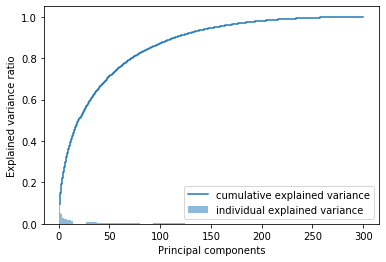

In [242]:
plt.bar(range(1,301), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,301),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [250]:
#- From above we plot we can clealry observer that 150 dimension() are able to explain 95 %variance of data. 
#- so we will use first 150 principal components going forward and calulate the reduced dimensions.

P_reduce = np.array(eigvectors_sorted[0:150])   # Reducing to 150 dimension space
X_std_8D = np.dot(X_std,P_reduce.T)   # projecting original data into principal component dimensions
reduced_pca = pd.DataFrame(X_std_8D)  # converting array to dataframe for pairplot
reduced_pca

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.924283,-1.586284,-0.485865,7.655915,3.587194,0.199741,2.256775,-6.201662,1.215905,-4.535800,...,-1.510830,1.227340,1.296891,-0.563117,0.266437,-0.125777,-1.345115,-0.054795,-0.440451,0.249569
1,-4.354417,5.229305,-1.959389,2.978332,0.412171,-1.389855,0.518221,-1.476101,-3.039090,-3.875005,...,-0.688227,0.948851,0.518152,-0.057214,-0.793203,-0.884749,2.024397,-0.999712,-1.406108,0.127829
2,5.263466,3.622985,9.815341,-0.723686,-1.564055,2.245710,-1.680246,-1.039501,0.075913,0.394320,...,1.212386,-0.248599,0.421486,-0.361899,0.318588,-0.428495,-0.224825,0.278727,0.360002,-0.746548
3,-5.693580,1.918214,1.367169,1.199841,-1.145156,-0.585371,-2.646682,1.050062,2.757917,4.083441,...,-0.136767,0.858623,0.301772,-0.643897,-0.178594,-1.395644,-0.681553,-0.016122,0.435189,0.479097
4,-0.254382,-3.889613,-0.255105,-2.839290,-0.714791,-3.074133,1.807195,0.987018,2.107474,2.318562,...,0.702585,0.290057,0.067692,1.257342,0.176317,-0.484670,-0.708134,-0.103238,0.082179,-0.428599
5,-3.377478,-2.063916,-4.107350,1.678071,-0.965480,1.273627,-0.543682,-0.154709,-3.961710,0.501415,...,-0.404664,-0.024525,-0.312317,-0.381951,0.139330,0.066559,-0.624934,0.756673,0.705052,-0.322041
6,10.562697,3.026194,-3.792813,3.583933,-2.399687,-1.360209,-0.351017,0.034270,2.854024,0.551982,...,0.106966,0.260655,0.247423,-0.376748,0.402821,0.659524,-0.363926,1.388278,-0.123142,0.896781
7,10.994013,-0.437851,-0.726623,-7.668480,-3.646995,2.231095,0.962634,-3.481081,-0.740337,-0.693384,...,-0.430272,-0.640222,-0.517948,-0.257411,0.126386,-0.185202,-0.153972,0.269375,0.034734,0.387642
8,-1.659735,-3.478257,0.218928,-2.315211,-0.028869,-1.073701,-0.853646,1.424941,-1.354927,-0.901791,...,0.283289,0.143907,0.876641,-1.599861,0.208549,-0.817678,1.250293,-0.120224,0.300804,-0.111032
9,-4.129520,5.184104,5.336523,-1.028445,-0.431221,0.766464,5.358783,-0.895417,-2.277702,1.848040,...,0.621284,-0.564755,1.150324,0.097697,-0.319204,0.867361,-0.349786,0.276468,-0.529190,-0.245111


In [ ]:
sns.pairplot(reduced_pca, diag_kind='kde') 
#sns.pairplot(reduced_pca1, diag_kind='kde')

KeyboardInterrupt: 